In [6]:
import os
from pprint import pprint
import json

# Run_types
U listu run_types spremi sva imena fileova koja ce se koristiti

In [7]:
run_types = ["normal", "replace_distractor_with_question", "gibberish_keep_none_of_above", "gibberish_all"]

In [8]:
def contain_string(string):
    def f(x):
        return string in x
    return f

In [9]:
def get_files_in_dir(directory_path):
    files_list = []
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file)
            files_list.append(file_path)
    return files_list

In [10]:
def load_file_results(file_path, accuracy_type=None):
    if accuracy_type is None:
        accuracy_type = 'over_all accuracy'
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Find the start of the JSON content
    json_start = content.find("{")
    
    if json_start == -1:
        raise ValueError("No JSON content found in file.")
    
    # Extract and parse the JSON content
    json_content = content[json_start:]
    data = json.loads(json_content)
    
    accuracies = {
        'sentence': data['sentence'][accuracy_type],
        'wordplay': data['wordplay'][accuracy_type],
        'all': data['all'][accuracy_type]
    }
    return accuracies

# load_file_results("llama-instruct/Meta-Llama-3-8B-Instruct_dem1-spec_1.txt")

In [11]:
def load_models(models, accuracy_type=None, skip_spec=False):
    global run_types
    models_dict = {}
    for model_dir in models:
        models_dict[model_dir] = {}
        if not skip_spec:
            models_dict[model_dir+"_spec"] = {}
        files_list = get_files_in_dir(model_dir)
        for file in files_list:
            results = load_file_results(file, accuracy_type)
            file_dir = model_dir
            if "spec_" in file:
                file_dir += "_spec"
                if skip_spec:
                    continue
            for run_type in run_types:
                if run_type in file:
                    models_dict[file_dir][run_type] = results
    return models_dict

In [124]:
latex_format = """
\\GRAPH {figname}
\\begin{{figure}}
\\begin{{center}}
\\begin{{tikzpicture}}
\\begin{{axis}}[
    %title={{{graph_name}}},
    symbolic x coords={{{x_axis}}}, ybar, 
    ylabel=Accuracy,
    ymin=0, ymax=1,
    xtick=data,
    legend style={{at={{(0.5,1.1)}}, anchor=north,legend columns=1, nodes={{scale=0.8}}}},
    x tick label style={{rotate=15, /pgf/number format/1000 sep=}},
    enlarge x limits={{0.22}},
    bar width=4pt
    ]
{plots}
\\legend{{{colors}}}
\\end{{axis}}
\\end{{tikzpicture}}
% \\caption{{Add description}}
\\label{{fig:{figname}}}
\\end{{center}}
\\end{{figure}}
\\ENDGRAPH
"""

In [125]:
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracies(models, accuracy_group='sentence', accuracy_type=None, skip_spec=False):
    """
    Plots the accuracies as a bar plot.
    
    Parameters:
    results (dict): A dictionary with filenames as keys and extracted accuracies as values.
    accuracy_group (str): The type of accuracy to plot ('sentence' or 'wordplay').
    accuracy_type (str): The type of accuracy to plot ('over_all accuracy' or 'original_accuracy'...).
    """
    global run_types
    results = load_models(models, accuracy_type, skip_spec)
    models = list(results.keys())
    x = np.arange(len(models))  # the label locations
    width = 0.15  # the width of the bars
    fig, ax = plt.subplots(figsize=(12, 7))
    plt.grid()
    ax.set_ylim([0, 1])
    
    coordinates = []
    labels = []
    for i, run_type in enumerate(run_types):
        col = []
        for model in models:
            if run_type in results[model]:
                col.append(results[model][run_type][accuracy_group])
            else:
                col.append(0)
        label = run_types[run_type] if isinstance(run_types, dict) else run_type
        labels.append(label)
        coordinates.append(col)
        ax.bar(x + (i-2.5)*width, col, width, label=label)

    run_type_len = len(coordinates)
    model_len = len(coordinates[0])
    plot = f"\\addplot\n\tcoordinates {{{{{''.join(['{}']*model_len)}}}}};\n" * run_type_len
    coordinates_args = []
    for run_type_i in range(run_type_len):
        for model_i in range(model_len):
            coordinates_args.append(f"({models[model_i]}, {coordinates[run_type_i][model_i]})")
    plot = plot.format(*coordinates_args)
    colors = ', '.join(labels)
    x_axis = ', '.join(models)
    accuracy_text = f'{accuracy_group.capitalize()} {accuracy_type.capitalize() if accuracy_type is not None else "Accuracies"}'
    title = f'{accuracy_text} by Model and Prompt'
    print(latex_format.format(graph_name=title, x_axis=x_axis, colors=colors, plots=plot, figname="graph1"))

    ax.set_xlabel('Models')
    ax.set_ylabel(accuracy_text)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    fig.tight_layout()
    plt.show()

    # x = np.arange(len(run_types))
    # for i, model in enumerate(models):
    #     col = []
    #     for run_type in run_types:
    #         if run_type in results[model]:
    #             col.append(results[model][run_type][accuracy_group])
    #         else:
    #             col.append(0)
    #     ax.bar(x + (i-2.5)*width, col, width, label=model)
    # ax.set_xlabel('Run types')
    # accuracy_text = f'{accuracy_group.capitalize()} {accuracy_type.capitalize() if accuracy_type is not None else "Accuracies"}'
    # ax.set_ylabel(accuracy_text)
    # ax.set_title(f'{accuracy_text} by Model and Prompt')
    # ax.set_xticks(x)
    # ax.set_xticklabels(run_types, rotation=45, ha='right')
    # ax.legend()
    # fig.tight_layout()
    # plt.show()




\GRAPH graph1
\begin{figure}
\begin{center}
\begin{tikzpicture}
\begin{axis}[
    %title={All Over_all accuracy by Model and Prompt},
    symbolic x coords={gemma-instruct, llama-instruct, mistral-instruct, phi3-instruct}, ybar, 
    ylabel=Accuracy,
    ymin=0, ymax=1,
    xtick=data,
    legend style={at={(0.5,1.1)}, anchor=north,legend columns=1, nodes={scale=0.8}},
    x tick label style={rotate=15, /pgf/number format/1000 sep=},
    enlarge x limits={0.22},
    bar width=4pt
    ]
\addplot
	coordinates {(gemma-instruct, 0.5448504983388704)(llama-instruct, 0.5669988925802879)(mistral-instruct, 0.4950166112956811)(phi3-instruct, 0.4717607973421927)};
\addplot
	coordinates {(gemma-instruct, 0.5238095238095237)(llama-instruct, 0.5802879291251384)(mistral-instruct, 0.3875968992248062)(phi3-instruct, 0.35437430786268)};
\addplot
	coordinates {(gemma-instruct, 0.46511627906976744)(llama-instruct, 0.49280177187153934)(mistral-instruct, 0.32115171650055374)(phi3-instruct, 0.25913621262458

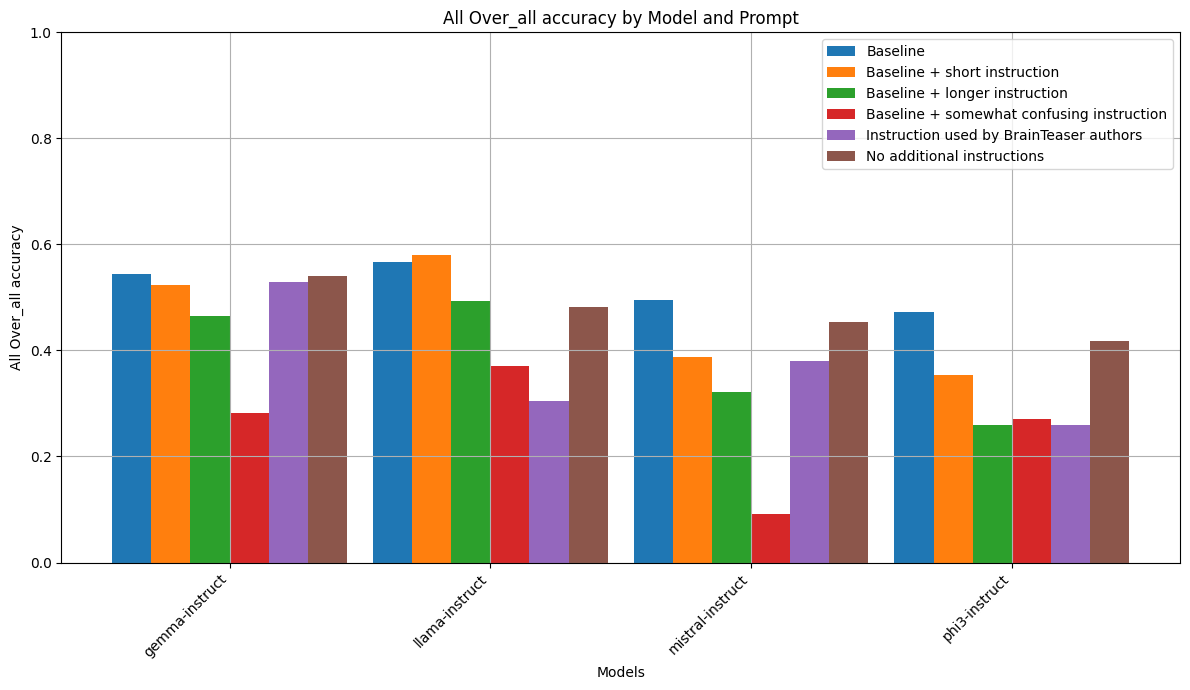

In [126]:
# run_types = {"normal": "No additional prompt",
#              "dem3": "The following question is a brainteaser.",
#              "dem2": "The following question is a brainteaser. One choice is correct, other choices are semanticaly derived from the question.",
#              "dem4": "The following question is a brainteaser. One choice is correct, other choices are semanticaly derived from the question. Sometimes none of the above is correct.",
#              "dem5": "The following question is a brainteaser. Sometimes none of the above is correct.",
#              "dem1": "Please pick the best choice for the brain teaser. Each brain teaser has only one possible solution including the choice none of above, answer should only provide the choice.",}

run_types = {
    "dem3": "Baseline",
    "dem2": "Baseline + short instruction",
    "dem4": "Baseline + longer instruction",
    "dem5": "Baseline + somewhat confusing instruction",
    "dem1": "Instruction used by BrainTeaser authors",
    "normal": "No additional instructions",
}



models = [
    # "falcon-7b-instruct",
    "gemma-instruct",
    "llama-instruct",
    "mistral-instruct",
    "phi3-instruct",
    # "Yi-1.5-9B-Chat"
]

accuracy_type = 'over_all accuracy'
accuracy_type = 'original_accuracy'
accuracy_type = 'semantic_accuracy'
accuracy_type = 'context_accuracy'

# plot_accuracies(models, accuracy_group="wordplay", accuracy_type=accuracy_type)
# plot_accuracies(models, accuracy_group="sentence", accuracy_type=accuracy_type)
# plot_accuracies(models, accuracy_group="all", accuracy_type='original_accuracy')
# plot_accuracies(models, accuracy_group="all", accuracy_type='context_accuracy')
plot_accuracies(models, accuracy_group="all", accuracy_type='over_all accuracy', skip_spec=True)
# plot_accuracies(models, accuracy_group="sentence", accuracy_type='over_all accuracy', skip_spec=False)

In [94]:

""""
\\addplot
	coordinates {{{}, {}, {}, {}, {}, {}}};
\\addplot
	coordinates {{{}, {}, {}, {}, {}, {}}};
\\addplot
	coordinates {{{}, {}, {}, {}, {}, {}}};
\\addplot
	coordinates {{{}, {}, {}, {}, {}, {}}};
""".format(*list(range(24)))

'"\n\\addplot\n\tcoordinates {0, 1, 2, 3, 4, 5};\n\\addplot\n\tcoordinates {6, 7, 8, 9, 10, 11};\n\\addplot\n\tcoordinates {12, 13, 14, 15, 16, 17};\n\\addplot\n\tcoordinates {18, 19, 20, 21, 22, 23};\n'